# SMAP数据获取

看看如何下载并读取SMAP数据。主要参考资料如下：

- [nsidc/smap_python_notebooks](https://github.com/nsidc/smap_python_notebooks)
- [TUW-GEO/smap_io](https://github.com/TUW-GEO/smap_io)
- [Docs » smap_io](https://smap-io.readthedocs.io/en/latest/)

在网站上手动下载的方式可以参考[这里](https://www.mtu.edu/mtri/research/outreach/soil-moisture/smap-worldview-how-to.pdf)

其他比如R语言工具可以参考[这里](https://github.com/ropensci/smapr)

python下直接使用 `requests` 库来批量下载 SMAP 数据。

## 从 NSIDC 批量下载数据

* [这里](https://nsidc.org/support/faq/what-options-are-available-bulk-downloading-data-https-earthdata-login-enabled) 有更多关于从 NSIDC 下载数据的说明
* SMAP 数据通过下面的地址获取（需要earth data账户，如果要创建一个NASA Earthdata登录账户，请到[Earthdata登录网站](https://urs.earthdata.nasa.gov/)；可能也需要科学上网）:
    * https://n5eil02u.ecs.nsidc.org/opendap/SMAP/
* 下面的例子是 **SPL3SMP version 007**，其他数据获取方法类似

import packages

In [1]:
import calendar
import os

import requests

Create a directory to store our data downloads.

In [2]:
this_dir = os.getcwd()
DATA_DIR = os.path.join(this_dir, 'data/L3_SM_P')

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

下面创建一个函数来返回我们想要下载的数据的网址和文件名。

对于SMAP数据，按年、月、日来，文件名的其余部分是可以预测的。

In [12]:
def SMAP_L3_P_36km_Path(year, month, day):
    fpath_start = 'https://n5eil01u.ecs.nsidc.org/SMAP/'
    host = 'https://n5eil01u.ecs.nsidc.org/'
    version = '.007'
    url_path = '{host}/SMAP/SPL3SMP{version}/{year}.{month:02}.{day:02}/'.format(host=host,
                                                                                 version=version,
                                                                                 year=year,
                                                                                 month=month,
                                                                                 day=day)
    filename = 'SMAP_L3_SM_P_{year}{month:02}{day:02}_R17000_001.h5'.format(year=year, 
                                                                            month=month, 
                                                                            day=day)

    smap_data_path = url_path + filename
    
    return smap_data_path, filename

为用户名和密码添加变量，请编辑一个.netrc文件如下所示，然后将该文件放到home文件夹下面。

```.netrc
machine urs.earthdata.nasa.gov
login <你的用户名>
password <你的密码>
```

*注意：不要与任何人分享你的用户名和密码！*。

In [13]:
from netrc import netrc
import os
netrcDir = os.path.expanduser(os.path.join("~",".netrc"))
urs = 'urs.earthdata.nasa.gov'
username=netrc(netrcDir).authenticators(urs)[0]
password=netrc(netrcDir).authenticators(urs)[2]

assert username and password, 'You must supply your Earthdata username and password!'

下面尝试下载2017年3月的数据

In [14]:
# Download data for March 2017
year = 2017
month = 3
_, days_in_month = calendar.monthrange(2017, 3)  # 31 days in March 2017

# Use a requests session to keep track of authentication credentials
with requests.Session() as session:
    session.auth = (username, password)
    
    for day in range(1, days_in_month + 1):
        print('Downloading SMAP data for: '+str(year)+'-'+str(month).zfill(2)+'-'+str(day).zfill(2))

        full_path, file_name = SMAP_L3_P_36km_Path(year, month, day)
        filepath = os.path.join(DATA_DIR, file_name)

        response = session.get(full_path)
        # If the response code is 401, we still need to authorize with earthdata.
        if response.status_code == 401:
            response = session.get(response.url)
        assert response.ok, 'Problem downloading data! Reason: {}'.format(response.reason)

        with open(filepath, 'wb') as f:
            f.write(response.content)

        print(file_name + ' downloaded')
        print('*** SM data saved to: '+ filepath +' *** ')

SMAP_L3_SM_P_20170301_R17000_001.h5 downloaded
*** SM data saved to: G:\Code\aqualord\SMAP\data/L3_SM_P\SMAP_L3_SM_P_20170301_R17000_001.h5 *** 
SMAP_L3_SM_P_20170302_R17000_001.h5 downloaded
*** SM data saved to: G:\Code\aqualord\SMAP\data/L3_SM_P\SMAP_L3_SM_P_20170302_R17000_001.h5 *** 
SMAP_L3_SM_P_20170303_R17000_001.h5 downloaded
*** SM data saved to: G:\Code\aqualord\SMAP\data/L3_SM_P\SMAP_L3_SM_P_20170303_R17000_001.h5 *** 
SMAP_L3_SM_P_20170304_R17000_001.h5 downloaded
*** SM data saved to: G:\Code\aqualord\SMAP\data/L3_SM_P\SMAP_L3_SM_P_20170304_R17000_001.h5 *** 
SMAP_L3_SM_P_20170305_R17000_001.h5 downloaded
*** SM data saved to: G:\Code\aqualord\SMAP\data/L3_SM_P\SMAP_L3_SM_P_20170305_R17000_001.h5 *** 
SMAP_L3_SM_P_20170306_R17000_001.h5 downloaded
*** SM data saved to: G:\Code\aqualord\SMAP\data/L3_SM_P\SMAP_L3_SM_P_20170306_R17000_001.h5 *** 
SMAP_L3_SM_P_20170307_R17000_001.h5 downloaded
*** SM data saved to: G:\Code\aqualord\SMAP\data/L3_SM_P\SMAP_L3_SM_P_20170307_R170

现在就有了批量下载的工具了!

**FYI这些脚本可能需要很长的时间，特别是如果下载较大的文件。
* SMAP 36公里的数据为30MB。
* SMAP 9公里的数据是~300MB
* SMAP 3公里的数据是~2GB

** 这就是为什么OPENDAP在某些情况下更有意义 **

更多关于如何通过[WGET](https://www.gnu.org/software/wget/)和[OPENDAP](https://www.opendap.org)从[NSIDC 数据门户](https://n5eil01u.ecs.nsidc.org/SMAP/)获得SMAP数据的地方和方法可以参考以下资料，这里暂不尝试了。

- [What is OPeNDAP?](https://earthdata.nasa.gov/collaborate/open-data-services-and-software/api/opendap)
- [Easy access to the NASA HDF products via OPeNDAP’s Hyrax](https://www.hdfgroup.org/2016/04/access-nasa-hdf-products-via-opendap-hyrax/)

## SMAP数据处理演示

下面的脚本提供了关于如何完成以下任务的例子。

1. 读入SMAP数据并浏览元数据
2. 用SMAP数据创建一个地图
3. 在地球上的某个位置绘制时间序列图

In [15]:
import datetime as dt
import glob
import h5py
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import xarray as xr

In [17]:
import cartopy

### 读取SMAP数据

* 首先我们进入到装有我们想用于演示的数据的文件夹。
* 列出文件夹内的文件清单并打印出来。

In [18]:
this_dir = os.getcwd()
L3_SM_P_dir = os.path.join(this_dir, 'data/L3_SM_P/')

flist = glob.glob(os.path.join(L3_SM_P_dir, '*.h5'))
           
filename = flist[0]; 
print("File we are using: " + filename + '\n')

File we are using: G:\Code\aqualord\SMAP\data/L3_SM_P\SMAP_L3_SM_P_20170301_R17000_001.h5



* 现在用h5py.File()来打开这个文件
* 然后可以查看文件中的文件夹来访问我们想要的数据

In [19]:
f = h5py.File(filename, 'r')
print('By using the command h5py.File() a filehandle is returned:')
print(f); print('\n')

print("Now lets look at the groups within the file to access:")
i=0;
for key in f.keys():
    print(str(i)+ '\t'+key)
    i+=1
group_id=list(f.keys())[1];# < Lets focus on the AM overpass for this example
print('\n')
i=0
print("Now lets look at the variables within the filegroup **Soil_Moisture_Retrieval_Data_AM** to access the actual data:")
for var in list(f[group_id].keys()):
    print(str(i)+'\t'+var)
    i+=1

By using the command h5py.File() a filehandle is returned:
<HDF5 file "SMAP_L3_SM_P_20170301_R17000_001.h5" (mode r)>


Now lets look at the groups within the file to access:
0	Metadata
1	Soil_Moisture_Retrieval_Data_AM
2	Soil_Moisture_Retrieval_Data_PM


Now lets look at the variables within the filegroup **Soil_Moisture_Retrieval_Data_AM** to access the actual data:
0	EASE_column_index
1	EASE_row_index
2	albedo
3	albedo_dca
4	albedo_scah
5	albedo_scav
6	boresight_incidence
7	bulk_density
8	clay_fraction
9	freeze_thaw_fraction
10	grid_surface_status
11	landcover_class
12	landcover_class_fraction
13	latitude
14	latitude_centroid
15	longitude
16	longitude_centroid
17	radar_water_body_fraction
18	retrieval_qual_flag
19	retrieval_qual_flag_dca
20	retrieval_qual_flag_scah
21	retrieval_qual_flag_scav
22	roughness_coefficient
23	roughness_coefficient_dca
24	roughness_coefficient_scah
25	roughness_coefficient_scav
26	soil_moisture
27	soil_moisture_dca
28	soil_moisture_error
29	soil_moisture_s

好了，现在我们知道了Soil_Moisture_Retrieval_Data_AM中的变量，让我们来抓取我们想做的土壤湿度图的数据。

* 首先让我们看一下形状
    - 我们稍后在打开经纬度数据集时将需要它。

In [20]:
print('the data has a shape of: '+str(f[group_id][list(f[group_id].keys())[0]].shape))

the data has a shape of: (406, 964)


* 现在从上面选择键，得到我们要绘制的变量。

In [21]:
var_id = list(f[group_id].keys())[26] # soil_moisture
sm_data = f[group_id][var_id][:,:]
sm_ds = f[group_id][var_id]
print('data are returned as '+str(type(sm_data)) + ' something easy to work with in python.')

data are returned as <class 'numpy.ndarray'> something easy to work with in python.


In [22]:
ret_flag_L3_P = f[group_id]['retrieval_qual_flag'][:,:]
print(np.unique(ret_flag_L3_P))
print(type(ret_flag_L3_P))

[ 0  1  5  7  8  9 13 15]
<class 'numpy.ndarray'>


### Create a map with SMAP data
* Lets plot the data to get a sense of what we are working with

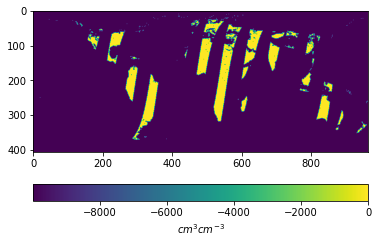

In [23]:
plt.imshow(sm_data)
cbar = plt.colorbar(orientation = 'horizontal')
cbar.set_label('$cm^3 cm^{-3}$')

Ok we have to ignore the null values to get a better idea of the range in values of the dataset.

You can find these null values in the meta data of the supplemental documents.

We know for soil moisture and most smap datasets it to be -9999.
This is located under the attributes for the 'soil_moisture' variable

In [ ]:
print(f[group_id][var_id].attrs['_FillValue'])

In [ ]:
sm_data[sm_data==f[group_id][var_id].attrs['_FillValue']]=np.nan;
plt.imshow(sm_data,vmin=0.,vmax=0.55, cmap = 'terrain_r');
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('$cm^3 cm^{-3}$')

How about we spruce this up with some coastlines, and geolocate the data using the lat, lon data?

Below we load the EASE2 grid lon and lat datasets.  These can be found on the NSIDC website.

In [ ]:
# Read binary files and reshape to correct size
lats = np.fromfile('EASE2_M36km.lats.964x406x1.double', 
                      dtype=np.float64).reshape((406,964))#< reshape to dimensions above
lons = np.fromfile('EASE2_M36km.lons.964x406x1.double', 
                      dtype=np.float64).reshape((406,964))

Now lets use basemap to plot the dataset

There are many online tutorials for basemap, to focus in on a region, and it provides lots of ways to display the data.

In [ ]:
fig = plt.figure(figsize=(10,6))
m = Basemap(resolution='l',projection='robin',lat_ts=40,lat_0=lats.mean(),lon_0=lons.mean())
xi, yi = m(lons, lats)
cs = m.pcolor(xi,yi,sm_data, vmin = 0., vmax = 0.55, cmap = 'terrain_r')
m.drawcoastlines()
cbar = m.colorbar(cs, location='bottom', pad="5%")
cbar.set_label('$cm^3 cm^{-3}$')

Awesome! We now can make a global plot, lets see if we can make this a bit more streamlined to process more data and create a time series.

### Plot a time-series at a location on Earth
* Lets stick with the L3 SM P dataset because the data isnt that big and its what I could put on your flashdrives for the demo.

Lets start by navigating back to the L3_SM_P directory & creating a filelist and a make a 3-d array to work wiht

In [ ]:
for fName in flist:
    print(fName)

* Lets make a function to load some data.



In [ ]:
def read_SML3P(filepath):
    ''' This function extracts lat, lon and soil moisture from SMAP L3 P HDF5 file.
    
    Parameters
    ----------
    filepath : str
        File path of a SMAP L3 HDF5 file
    Returns
    -------
    soil_moisture_am: numpy.array
    '''    
    with h5py.File(filepath, 'r') as f:
        # Extract data info
        group_id_am = 'Soil_Moisture_Retrieval_Data_AM'
        var_id_am = 'soil_moisture'
        flag_id_am = 'retrieval_qual_flag'
        soil_moisture_am = f[group_id_am][var_id_am][:,:]
        flag_am = f[group_id_am][flag_id_am][:,:]
        soil_moisture_am[soil_moisture_am==-9999.0]=np.nan;
        soil_moisture_am[(flag_am>>0)&1==1]=np.nan
        filename = os.path.basename(filepath)
        yyyymmdd= filename.split('_')[4]
        yyyy = int(yyyymmdd[0:4]);        mm = int(yyyymmdd[4:6]);        dd = int(yyyymmdd[6:8])
        date=dt.datetime(yyyy,mm,dd)
    return soil_moisture_am,date

* Lets check if it works:

In [ ]:
sm_test,date = read_SML3P(flist[0])
plt.imshow(sm_test)
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('$cm^3 cm^{-3}$')
plt.title(date)

* Now that we have that working lets add everything to a 3-d array, remember time is the 3rd dimension
* For larger datasets (i.e. 3km data or even 9km data you need to get creative to do on your local machine)

In [ ]:
sm_data_3d = np.empty([sm_data.shape[0],sm_data.shape[1],len(flist)])
times = []
print('sm_data_3d has dimensions '+str(sm_data_3d.shape))
i=0
for fName in flist:
    sm_data_3d[:,:,i],time_i = read_SML3P(fName)
    times.append(time_i)
    i+=1

In [ ]:
sm_mean = np.nanmean(sm_data_3d,2)
sm_mean.shape
plt.imshow(sm_mean,vmin=0.,vmax=0.55,cmap='terrain_r')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('$cm^3 cm^{-3}$')

In [ ]:
N_lat = 37.5; 
S_lat = 33
W_lon = -113.5
E_lon = -110.0

subset = (lats<N_lat)&(lats>S_lat)&(lons>W_lon)&(lons<E_lon);
sm_time = np.empty([len(flist)]);
for i in np.arange(0,sm_data_3d.shape[2]):
    sm_2d = sm_data_3d[:,:,i]
    sm_time[i] = np.nanmean(sm_2d[subset]); 

# Lets create a pandas series to plot the data
smData = {'sm':sm_time}
sm = pd.DataFrame(smData)
sm['time']=times
sm=sm.set_index('time')

fig, ax1 = plt.subplots()
ax1.plot(sm.index, sm, 'b*')       
ax1.set_ylim([0,0.25])
fig.autofmt_xdate()
ax1.set_ylabel('$cm^3 cm^{-3}$')
plt.title('Soil Moisture')

## Quality Flags & SMAP Data

* Retrieval Quality Flag [combines all surface flags]
* Surface Quality Flag [provides information on why certain area might be flagged]


In [ ]:
import datetime as dt
import glob
import h5py
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

    Read in SMAP data for level 3 dataset for this example

In [ ]:
this_dir = os.getcwd()
L3_SM_P_dir = os.path.join(this_dir, 'data/L3_SM_P/')

flist = glob.glob(os.path.join(L3_SM_P_dir, '*.h5'))
filename = flist[0]; 

Ok now lets read in variables: soil_moisture, 

In [ ]:
f = h5py.File(filename, 'r')
group_id = 'Soil_Moisture_Retrieval_Data_AM'
var_id = list(f[group_id].keys())[16] # soil_moisture
sm_data = f[group_id][var_id][:,:]
surf_flag_L3_P = f[group_id]['surface_flag'][:,:]

    data are returned as <type 'numpy.ndarray'> something easy to work with in python.


Lets look at the two masks:

**Retrieval Flags**

To clear up any confusion from the workshop on quality masking:

I used over-simplified approaches to applying quality flags within the demo scripts that were hasty.
Below are better documented directions to applying the recommended quality flags for SMAP data.

Here I show the recommended quality flag from SMAP

In [ ]:
# Grab the Retrieval Quality Variable
ret_flag_L3_P = f[group_id]['retrieval_qual_flag'][:,:]
# Create a definition for the retrieval flags
ret_flags = {
    0:'Recommended Quality',
    1:'Retrieval Attempted',
    2:'Retrieval Successful',
    3:'Undefined'
}
# SMAP RECOMMENDED QUALITY BIT IS 0
fig, ax = plt.subplots()

cax = ax.imshow((ret_flag_L3_P>>0)&1, cmap=plt.cm.get_cmap('bone', 2))
ax.set_title(ret_flags[0])

cbar = fig.colorbar(cax, ticks=[0, 1], orientation='horizontal')
cbar.ax.set_xticklabels(['Good Data', 'Not Recommended'])  # horizontal colorbar

plt.show()


Areas above with 0 value [black regions] are data of recommended quality.

**Surface Flags**

In [ ]:
surf_flags = {
    0:'Static water',
    1:'Radar-derived Water Fraction',
    2:'Coastal Proximity',
    3:'Urban Area',
    4:'Precipitation',
    5:'Snow',
    6:'Ice',
    7:'Frozen Ground (model)',
    8:'Frozen Ground (radar)',
    9:'Mountainous Terrain',
    10:'Dense Vegetation',
    11:'Nadir Region',
    12:'Undefined'
}

* Based off the above recommended quality flags above the surface flags that inhibit recommende quality are as follows.  
* Black areas show no flag, white areas show where flagged data occcur.

In [ ]:
for i in np.arange(0,12):
    fig, ax = plt.subplots()
    cax = ax.imshow((surf_flag_L3_P>>i)&1, cmap=plt.cm.get_cmap('bone', 2))
    ax.set_title(surf_flags[i])
    cbar = fig.colorbar(cax, ticks=[0, 1], orientation='horizontal')
    cbar.ax.set_xticklabels(['No Flag', 'Flag Present'])  # horizontal colorbar
    plt.show()